In [1]:
import os
import warnings

warnings.filterwarnings('ignore')
os.chdir('../../..')

In [22]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss

In [18]:
from pytorch_forecasting.data.examples import get_stallion_data

data = get_stallion_data()

data['time_idx'] = data['date'].dt.year*12 + data['date'].dt.month
data['time_idx'] -= data['time_idx'].min()

data['month'] = data.date.dt.month.astype(str).astype('category')
data['log_volume'] = np.log(data.volume + 1e-8)
data['avg_volume_by_sku'] = data.groupby(['time_idx','sku'], observed=True).volume.transform('mean')
data['avg_volume_by_agency'] = data.groupby(['time_idx','agency'], observed=True).volume.transform('mean')

special_days= [
    'easter_day',
    'good_friday',
    'christmas',
    'labor_day',
    'independence_day',
    'revolution_day_memorial',
    'regional_games',
    'fifa_u_17_world_cup',
    'football_gold_cup',
    'beer_capital',
    'music_fest',
]

data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype('category')
data.sample(10, random_state=521)


,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,easter_day,good_friday,new_year,christmas,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
291,Agency_25,SKU_03,0.5076,2013-01-01,492612703,718394219,25.845238,1264.162234,1152.473405,111.688829,53598,95032,-,-,1,-,-,-,-,-,-,-,-,-,8.835008,228,0,1,-0.678062,1225.306376,99.650400
871,Agency_29,SKU_02,8.7480,2015-01-01,498567142,762225057,27.584615,1316.098485,1296.804924,19.293561,28329,93614,-,-,1,-,-,-,-,-,-,-,-,-,1.465966,177,24,1,2.168825,1634.434615,11.397086
19532,Agency_47,SKU_01,4.9680,2013-09-01,454252482,789624076,30.665957,1269.250000,1266.490490,2.759510,32183,128574,-,-,0,-,-,independence_day,-,-,-,-,-,-,0.217413,322,8,9,1.603017,2625.472644,48.295650
2089,Agency_53,SKU_07,21.6825,2013-10-01,480693900,791658684,29.197727,1193.842373,1128.124395,65.717978,1729177,111048,-,-,0,-,-,-,-,-,-,-,beer_capital,-,5.504745,240,9,10,3.076505,38.529107,2511.035175
9755,Agency_17,SKU_02,960.5520,2015-03-01,515468092,871204688,23.608120,1338.334248,1232.128069,106.206179,147910,123013,-,-,0,-,-,-,-,-,-,-,-,music_fest,7.935699,259,26,3,6.867508,2143.677462,396.022140
7561,Agency_05,SKU_03,1184.6535,2014-02-01,425528909,734443953,28.668254,1369.556376,1161.135214,208.421162,3044268,182944,-,-,0,-,-,-,-,-,-,-,-,-,15.218151,21,13,2,7.077206,1566.643589,1881.866367
19204,Agency_11,SKU_05,5.5593,2017-08-01,623319783,1049868815,31.915385,1922.486644,1651.307674,271.178970,135561,100461,-,-,0,-,-,-,-,-,-,-,-,-,14.105636,17,55,8,1.715472,1385.225478,109.699200
8781,Agency_48,SKU_04,4275.1605,2013-03-01,509281531,892192092,26.767857,1761.258209,1546.059670,215.198539,1739969,210213,easter_day,good_friday,0,-,-,-,-,-,-,-,-,music_fest,12.218455,151,2,3,8.360577,1757.950603,1925.272108
2540,Agency_07,SKU_21,0.0000,2015-10-01,544203593,761469815,28.987755,0.000000,0.000000,0.000000,1868030,175785,-,-,0,-,-,-,-,-,-,-,-,-,0.000000,300,33,10,-18.420681,0.000000,2418.719550
12084,Agency_21,SKU_03,46.3608,2017-04-01,589969396,940912941,32.478910,1675.922116,1413.571789,262.350327,26635,130092,easter_day,good_friday,0,-,-,-,-,-,-,-,-,-,15.654088,181,51,4,3.836454,2034.293024,109.381800


In [19]:
data.describe()

,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,new_year,discount_in_percent,timeseries,time_idx,log_volume,avg_volume_by_sku,avg_volume_by_agency
count,21000.000000,21000,2.100000e+04,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.00000,21000.000000,21000.000000,21000.000000,21000.000000
mean,1492.403982,2015-06-16 20:48:00,5.439214e+08,8.512000e+08,28.612404,1451.536344,1267.347450,184.374146,1.045065e+06,151073.494286,0.083333,10.574884,174.50000,29.500000,2.464118,1492.403982,1492.403982
min,0.000000,2013-01-01 00:00:00,4.130518e+08,6.964015e+08,16.731034,0.000000,-3121.690141,0.000000,1.227100e+04,90240.000000,0.000000,0.000000,0.00000,0.000000,-18.420681,0.000000,0.000000
25%,8.272388,2014-03-24 06:00:00,5.090553e+08,7.890880e+08,25.374816,1311.547158,1178.365653,54.935108,6.018900e+04,110057.000000,0.000000,3.749628,87.00000,14.750000,2.112923,932.285496,113.420250
50%,158.436000,2015-06-16 00:00:00,5.512000e+08,8.649196e+08,28.479272,1495.174592,1324.695705,138.307225,1.232242e+06,131411.000000,0.000000,8.948990,174.50000,29.500000,5.065351,1402.305264,1730.529771
75%,1774.793475,2016-09-08 12:00:00,5.893715e+08,9.005551e+08,31.568405,1725.652080,1517.311427,272.298630,1.729177e+06,206553.000000,0.000000,15.647058,262.00000,44.250000,7.481439,2195.362302,2595.316500
max,22526.610000,2017-12-01 00:00:00,6.700157e+08,1.049869e+09,45.290476,19166.625000,4925.404000,19166.625000,3.137874e+06,247220.000000,1.000000,226.740147,349.00000,59.000000,10.022453,4332.363750,5884.717375
std,2711.496882,NaN,6.288022e+07,7.824340e+07,3.972833,683.362417,587.757323,257.469968,9.291926e+05,50409.593114,0.276392,9.590813,101.03829,17.318515,8.178218,1051.790829,1328.239698


In [20]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff= data['time_idx'].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx='time_idx',
    target= 'volume',
    group_ids= ['agency','sku'],
    min_encoder_length= max_encoder_length // 2,
    max_encoder_length= max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=['agency','sku'],
    static_reals=['avg_population_2017','avg_yearly_household_income_2017'],
    time_varying_known_categoricals=['special_days','month'],
    variable_groups={'special_days': special_days},
    time_varying_known_reals=['time_idx','price_regular','discount_in_percent'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        'volume',
        'log_volume',
        'industry_volume',
        'soda_volume',
        'avg_max_temp',
        'avg_volume_by_agency',
        'avg_volume_by_sku',
    ],
    target_normalizer=GroupNormalizer(groups=['agency','sku'], transformation='softplus'),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size*10, num_workers=0)

In [23]:
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(293.0088)

In [26]:
pl.seed_everything(42)
trainer =pl.Trainer(
    accelerator='cpu',
    gradient_clip_val=0.1,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=8,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    optimizer='Ranger'
)

print(f'Number of parameters in network: {tft.size()/1e3:.1f}k')

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 13.5k


Finding best initial lr: 100%|██████████| 100/100 [00:49<00:00,  2.02it/s]
Learning rate set to 0.09332543007969905
Restoring states from the checkpoint path at c:\Users\CarlosHerediaPimient\.lr_find_195a4811-3728-4506-b03e-bc47f73cf337.ckpt
Restored all states from the checkpoint at c:\Users\CarlosHerediaPimient\.lr_find_195a4811-3728-4506-b03e-bc47f73cf337.ckpt


Suggested learning rate:0.09332543007969905


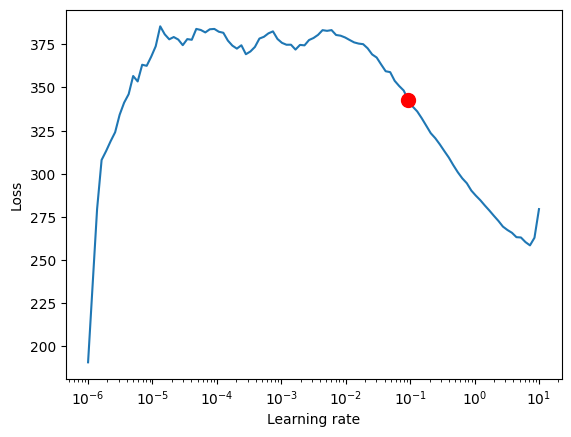

In [27]:
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f'Suggested learning rate:{res.suggestion()}')
fig = res.plot(show=True, suggest=True)
fig.show()

In [34]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

AttributeError: module 'tensorboard.compat.tensorflow_stub.io.gfile' has no attribute 'join'

In [30]:
early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=False, mode='min')
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger('lightning_logs')

trainer = pl.Trainer(
    max_epochs=50,
    accelerator='cpu',
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,
    callbacks=[lr_logger,early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,
    optimizer ='Ranger',
    reduce_on_plateau_patience=4,
)
print(f'Number of parameters in network: {tft.size()/1e3:.1f}k')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 29.4k
